In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision import models
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from efficientnet_pytorch import EfficientNet
from torch.optim.lr_scheduler import StepLR

### 시드설정함수

In [2]:
import random
import numpy as np

# 시드 설정 함수 정의
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 여러 GPU 사용 시
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 설정
set_seed(42)

In [3]:

# # 데이터 증강 및 정규화를 위한 변환 설정
# # train데이터는 데이터 증식이 필요
# # 데이터 증식 : 과적합을 피하기 위함
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),  # 데이터 증강: 랜덤하게 잘라내기
#     transforms.RandomHorizontalFlip(),      # 데이터 증강: 랜덤하게 좌우 반전
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # 정규화 rgb 평균갑 / rgb 표준편차값
# ])


# # 테스트 데이터는 데이터 증식을 하면 안된다.
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])


# # CIFAR10 데이터셋 불러오기
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
# test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


# # train/valid data 분리하기
# train_ratio = 0.8
# train_size = int(len(train_dataset) * train_ratio)
# val_size = len(train_dataset) - train_size
# train_dataset, valid_dataset = random_split(train_dataset, [train_size, val_size])


# # 데이터 로더 생성
# batch_size = 128  # 원하는 배치 크기 설정
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)    #num_worckers -> cpu 개수 / 이미지가 커지면 4~8개까지 줘야함 / 코랩에서는 2개이상 줄수없다.
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [4]:
# # 수정된 데이터 증강 코드
# # 증강 조건을 추가하여 더 많은 데이터를 학습 시켜보기
# transform_train = transforms.Compose([
#     transforms.RandomCrop(32, padding=4),            # 패딩 후 랜덤하게 자르기
#     transforms.RandomHorizontalFlip(),               # 좌우 반전
#     transforms.ToTensor(),                           # PIL 이미지를 텐서로 변환 (텐서로 변환 후 다음 변환 적용 - 순서 매우 중요)
#     transforms.RandomRotation(degrees=15),           # 약간의 회전
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상 변화
#     transforms.RandomErasing(p=0.5),                 # 랜덤한 부분 지우기
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))       # 정규화
# ])


# # 테스트 데이터는 데이터 증식을 하면 안된다.
# transform_test = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
# ])


# # CIFAR10 데이터셋 불러오기
# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
# test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


# # train/valid data 분리하기
# train_ratio = 0.8
# train_size = int(len(train_dataset) * train_ratio)
# val_size = len(train_dataset) - train_size
# train_dataset, valid_dataset = random_split(train_dataset, [train_size, val_size])


# # 데이터 로더 생성
# batch_size = 128  # 원하는 배치 크기 설정
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)    #num_worckers -> cpu 개수 / 이미지가 커지면 4~8개까지 줘야함 / 코랩에서는 2개이상 줄수없다.
# valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

### 데이터셋 로드 및 transforms
### 데이터 분리 및 데이터로더 객체생성

In [5]:
# IMAGE_SIZE = 224 # We need to resize the images given resnet takes input of image size >= 224

# mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
# # These values are mostly used by researchers as found to very useful in fast convergence


# # https://pytorch.org/vision/stable/transforms.html
# # We can try various transformation for good generalization of model
# composed_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 32X32 shape
#                                      transforms.RandomRotation(20), # Randomly rotate some images by 20 degrees
#                                      transforms.RandomHorizontalFlip(0.1), # Randomly horizontal flip the images
#                                      transforms.ColorJitter(brightness = 0.1, # Randomly adjust color jitter of the images
#                                                             contrast = 0.1, 
#                                                             saturation = 0.1), 
#                                      transforms.RandomAdjustSharpness(sharpness_factor = 2,
#                                                                       p = 0.1), # Randomly adjust sharpness
#                                      transforms.ToTensor(),   # Converting image to tensor
#                                      transforms.Normalize(mean, std), # Normalizing with standard mean and standard deviation
#                                      transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False)])

In [6]:
# import torch
# from torchvision import datasets, transforms
# from torch.utils.data import DataLoader, random_split

# def get_dataloaders(use_augmented=True, resize_images=True, batch_size=128, train_ratio=0.8):
#     IMAGE_SIZE = 224  # ResNet-34는 224x224 입력받도록 설계되어 있음
#     ORIGINAL_IMAGE_SIZE = 32  # 원래 CIFAR-10 이미지 크기

#     # 기본 데이터 증강
#     transform_train_basic = transforms.Compose([
#         transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)) if resize_images else transforms.RandomCrop(32, padding=4),  # 이미지 크기 조절
#         transforms.RandomHorizontalFlip(),  # 랜덤 좌우 반전
#         transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # 정규화
#     ])

#     # 추가된 데이터 증강 (더 많은 증강 추가)
#     transform_train_augmented = transforms.Compose([
#         transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)) if resize_images else transforms.RandomCrop(ORIGINAL_IMAGE_SIZE, padding=4),  # 이미지 크기 조절
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),  # 선명도 조정
#         transforms.RandomRotation(degrees=20),  # 약간의 회전
#         transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # 색상 변화
#         transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0),  # 랜덤 지우기
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # 정규화
#     ])

#     # 테스트 데이터 변환 (증강 없음)
#     transform_test = transforms.Compose([
#         transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)) if resize_images else transforms.ToTensor(),
#         transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#     ])

#     # 데이터 증강 선택 플래그에 따라 사용할 변환 선택
#     if use_augmented:
#         print("Using augmented data transformations.")
#         transform_train = transform_train_augmented
#     else:
#         print("Using basic data transformations.")
#         transform_train = transform_train_basic

#     # CIFAR10 데이터셋 로드
#     train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
#     test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

#     # 학습/검증 데이터셋 분리
#     train_size = int(len(train_dataset) * train_ratio)
#     val_size = len(train_dataset) - train_size
#     train_dataset, valid_dataset = random_split(train_dataset, [train_size, val_size])

#     # 데이터 로더 생성
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

#     return train_loader, valid_loader, test_loader

In [7]:
def get_dataloaders(use_augmented=True, resize_images=True, batch_size=128, train_ratio=0.8):
    IMAGE_SIZE = 224  # ResNet-34는 224x224 입력받도록 설계되어 있음
    ORIGINAL_IMAGE_SIZE = 32  # 원래 CIFAR-10 이미지 크기

    # 이미지 크기 조정 여부에 따른 변환 설정
    if resize_images:
        resize_transform = transforms.Resize((IMAGE_SIZE, IMAGE_SIZE))  # 224x224로 변경
    else:
        resize_transform = transforms.RandomCrop(ORIGINAL_IMAGE_SIZE, padding=4)  # 원래 크기 유지

    # 기본 데이터 증강
    transform_train_basic = transforms.Compose([
        resize_transform,  # 위에서 결정된 크기 조정 변환 사용
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # 정규화
    ])

    # 추가된 데이터 증강 (더 많은 증강 추가)
    transform_train_augmented = transforms.Compose([
        resize_transform,  # 위에서 결정된 크기 조정 변환 사용
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.1),  # 선명도 조정
        transforms.RandomRotation(degrees=20),  # 약간의 회전
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # 색상 변화
        transforms.RandomErasing(p=0.75, scale=(0.02, 0.1), value=1.0),  # 랜덤 지우기
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))  # 정규화
    ])

    # 테스트 데이터 변환 (증강 없음)
    transform_test = transforms.Compose([
        resize_transform,
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    # 데이터 증강 선택 플래그에 따라 사용할 변환 선택
    if use_augmented:
        print("Using augmented data transformations.")
        transform_train = transform_train_augmented
    else:
        print("Using basic data transformations.")
        transform_train = transform_train_basic

    # CIFAR-10 데이터셋 로드
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

    # 학습/검증 데이터셋 분리
    train_size = int(len(train_dataset) * train_ratio)
    val_size = len(train_dataset) - train_size
    train_dataset, valid_dataset = random_split(train_dataset, [train_size, val_size])

    # 데이터 로더 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, valid_loader, test_loader

In [8]:
# def get_dataloaders(use_augmented=True, batch_size=128, train_ratio=0.8):
#     IMAGE_SIZE = 224 #resnet34는 224*224 입력받도록 설계되어있음
#     # 기본 데이터 증강
#     transform_train_basic = transforms.Compose([
#         transforms.RandomCrop(32, padding=4),  # 데이터 증강: 랜덤하게 잘라내기
#         transforms.RandomHorizontalFlip(),      # 데이터 증강: 랜덤하게 좌우 반전
#         transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),  # 정규화 rgb 평균값 / rgb 표준편차값
#     ])

#     # 추가된 데이터 증강 (더 많은 증강 추가)
#     transform_train_augmented = transforms.Compose([
#         transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), # Resize the image in a 32X32 shape
#         # transforms.RandomCrop(32, padding=4),            # 패딩 후 랜덤하게 자르기
#         transforms.RandomHorizontalFlip(),               # 좌우 반전
#         transforms.ToTensor(),                           # PIL 이미지를 텐서로 변환
#         transforms.RandomAdjustSharpness(sharpness_factor = 2, p = 0.1), # Randomly adjust sharpness
#         transforms.RandomRotation(degrees=20),           # 약간의 회전
#         transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # 색상 변화
#         transforms.RandomErasing(p=0.75,scale=(0.02, 0.1),value=1.0, inplace=False),    # 랜덤한 부분 지우기
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))       # 정규화
#     ])

#     # 테스트 데이터 변환 (증강 없음)
#     transform_test = transforms.Compose([
#         transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
#     ])
    
#     # 데이터 증강 선택 플래그에 따라 사용할 변환 선택
#     if use_augmented:
#         print("Using augmented data transformations.")
#         transform_train = transform_train_augmented
#     else:
#         print("Using basic data transformations.")
#         transform_train = transform_train_basic

#     # CIFAR10 데이터셋 로드
#     train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
#     test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    
#     # 학습/검증 데이터셋 분리
#     train_size = int(len(train_dataset) * train_ratio)
#     val_size = len(train_dataset) - train_size
#     train_dataset, valid_dataset = random_split(train_dataset, [train_size, val_size])
    
#     # 데이터 로더 생성
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
#     valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    
#     return train_loader, valid_loader, test_loader

### CIFAR10Net 

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 입력 이미지(3,32,32)
# 출력 이미지(0~9)
classes = 10

class CIFAR10Net(nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()
        # 합성곱 레이어 1
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # 입력 채널: 3, 출력 채널: 32
        self.bn1 = nn.BatchNorm2d(32)  # 배치 정규화

        # 합성곱 레이어 2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) # 입력 채널: 32, 출력 채널: 64
        self.bn2 = nn.BatchNorm2d(64)

        # 합성곱 레이어 3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # 입력 채널: 64, 출력 채널: 128
        self.bn3 = nn.BatchNorm2d(128)

        # 완전 연결 레이어
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # 128 채널의 4x4 특성 맵을 512 유닛으로 변환
        self.fc2 = nn.Linear(512, classes)  # 512 유닛을 10개의 클래스로 변환

    def forward(self, x):
        # 합성곱 레이어 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 맥스 풀링

        # 합성곱 레이어 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 맥스 풀링

        # 합성곱 레이어 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2, stride=2)  # 맥스 풀링

        # 완전 연결 레이어
        x = x.view(-1, 128 * 4 * 4)  # 텐서를 1차원으로 펼치기
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [10]:
class CNN_V3_V4(nn.Module):
    """
    Adding one more hidden layer & dropout value & one more convolution layer
    Total 3 hidden layers, 3 convolution layer & Batch Normalization
    """
    # Constructor
    def __init__(self, out_1 = 32, out_2 = 64, out_3 = 128, number_of_classes = 10, p = 0):
        super(CNN_V3_V4, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels = 3, out_channels = out_1, kernel_size = 5, padding = 2)
        self.maxpool1 = nn.MaxPool2d(kernel_size = 2)
        self.conv1_bn = nn.BatchNorm2d(out_1)
        self.drop_conv = nn.Dropout(p=0.2)
        
        self.cnn2 = nn.Conv2d(in_channels = out_1, out_channels = out_2, kernel_size = 5, padding = 2)
        self.maxpool2 = nn.MaxPool2d(kernel_size = 2)
        self.conv2_bn = nn.BatchNorm2d(out_2)
        
        self.cnn3 = nn.Conv2d(in_channels = out_2, out_channels = out_3, kernel_size = 5, padding = 2)
        self.maxpool3 = nn.MaxPool2d(kernel_size = 2)
        self.conv3_bn = nn.BatchNorm2d(out_3)
        
        # Hidden layer 1
        self.fc1 = nn.Linear(out_3 * 4 * 4, 1000) 
        self.drop = nn.Dropout(p=p)
        self.fc1_bn = nn.BatchNorm1d(1000)
        
        # Hidden layer 2
        self.fc2 = nn.Linear(1000, 1000)
        self.fc2_bn = nn.BatchNorm1d(1000)

        # Hidden layer 3
        self.fc3 = nn.Linear(1000, 1000)
        self.fc3_bn = nn.BatchNorm1d(1000)
        
        # Hidden layer 4
        self.fc4 = nn.Linear(1000, 1000)
        self.fc4_bn = nn.BatchNorm1d(1000)
        
        # Final layer
        self.fc5 = nn.Linear(1000, 10)
        self.fc5_bn = nn.BatchNorm1d(10)
        
    # Predictiona
    def forward(self, x):
        
        x = self.cnn1(x)
        x = self.conv1_bn(x)
        x = self.maxpool1(x)
        x = self.drop_conv(x)
        
        x = self.cnn2(x)
        x = self.conv2_bn(x)
        x = torch.relu(x)
        x = self.maxpool2(x)
        x = self.drop_conv(x)
        
        x = self.cnn3(x)
        x = self.conv3_bn(x)
        x = torch.relu(x)
        x = self.maxpool3(x)
        x = self.drop_conv(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc1_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc2(x)
        x = self.fc2_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc3(x)
        x = self.fc3_bn(x)
        
        x = F.relu(self.drop(x))
        x = self.fc4(x)
        x = self.fc4_bn(x)

        x = F.relu(self.drop(x))
        x = self.fc5(x)
        x = self.fc5_bn(x)
        
        return(x)

In [11]:
def resnet_34():
    # Define the resnet model
    resnet = models.resnet34(pretrained=True)
    
    # Update the fully connected layer of resnet with our current target of 10 desired outputs
    resnet.fc = torch.nn.Linear(resnet.fc.in_features, 10)
    
    # Initialize with xavier uniform
    torch.nn.init.xavier_uniform_(resnet.fc.weight)
    return resnet

model_mmtv6 = resnet_34()

c:\Users\SBA\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SBA\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 디바이스 확인

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"


### 학습률/에폭수/데이터증강여부/모델을 설정
#### 이미지 사이즈 설정도 추가(resnet34는 224입력만 가능함)
### 손실함수 및 최적화알고리즘 정의

In [13]:
# lr = 0.001
# epochs = 50

# # 기본 데이터 증강 모드 or 추가된 데이터 증강 모드 선택하기 + 이미지 사이즈 설정(resnet34는 이미지 사이즈 224)
# train_loader, valid_loader, test_loader = get_dataloaders(use_augmented=False, resize_images = True)

# # EfficientNet 모델 불러오기 (사전 학습된 가중치 사용)
# model = EfficientNet.from_pretrained('efficientnet-b2')
# # model = CIFAR10Net().to(device)

# # 마지막 레이어 변경 (CIFAR-10은 10개의 클래스)
# num_classes = 10
# model._fc = nn.Linear(model._fc.in_features, num_classes)  # 마지막 레이어를 CIFAR-10에 맞게 변경
# model = model.to(device)

# # 손실 함수 정의
# criterion = nn.CrossEntropyLoss()
# # 최적화 알고리즘 정의
# optimizer = optim.Adam(model.parameters(), lr=lr)

In [14]:
lr = 0.001
epochs = 50

# 기본 데이터 증강 모드 or 추가된 데이터 증강 모드 선택하기 
train_loader, valid_loader, test_loader = get_dataloaders(use_augmented=True, resize_images =True)
# cnn_v3_v4(캐글)
# model = CNN_V3_V4(out_1=32, out_2=64, out_3 =128, number_of_classes = 10, p=0.5).to(device)
# cifar10Net
# model = CIFAR10Net().to(device)
# resnet_34(캐글)
model = resnet_34().to(device)
# 손실합수
criterion = nn.CrossEntropyLoss()
# 최적화 알고리즘
optimizer = optim.SGD(model.parameters(), lr=lr)

Using augmented data transformations.
Files already downloaded and verified
Files already downloaded and verified


In [15]:
# 모델 학습 시 함꼐 해도 될 듯듯
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

In [16]:
for name, param in model.named_parameters():
    print(f"Layer: {name} is on {param.device}")

Layer: conv1.weight is on cuda:0
Layer: bn1.weight is on cuda:0
Layer: bn1.bias is on cuda:0
Layer: layer1.0.conv1.weight is on cuda:0
Layer: layer1.0.bn1.weight is on cuda:0
Layer: layer1.0.bn1.bias is on cuda:0
Layer: layer1.0.conv2.weight is on cuda:0
Layer: layer1.0.bn2.weight is on cuda:0
Layer: layer1.0.bn2.bias is on cuda:0
Layer: layer1.1.conv1.weight is on cuda:0
Layer: layer1.1.bn1.weight is on cuda:0
Layer: layer1.1.bn1.bias is on cuda:0
Layer: layer1.1.conv2.weight is on cuda:0
Layer: layer1.1.bn2.weight is on cuda:0
Layer: layer1.1.bn2.bias is on cuda:0
Layer: layer1.2.conv1.weight is on cuda:0
Layer: layer1.2.bn1.weight is on cuda:0
Layer: layer1.2.bn1.bias is on cuda:0
Layer: layer1.2.conv2.weight is on cuda:0
Layer: layer1.2.bn2.weight is on cuda:0
Layer: layer1.2.bn2.bias is on cuda:0
Layer: layer2.0.conv1.weight is on cuda:0
Layer: layer2.0.bn1.weight is on cuda:0
Layer: layer2.0.bn1.bias is on cuda:0
Layer: layer2.0.conv2.weight is on cuda:0
Layer: layer2.0.bn2.weigh

### TRAIN

In [17]:
def train(model, device, train_loader, optimizer, epoch, epochs):
    # 훈련 모드 설정
    model.train()

    train_loss=0
    train_correct=0
    train_total=0

    startStr =f'Epoch {epoch+1:2d}/{epochs} \033[34m' + 'Train'+ '\033[0m'
    with tqdm(total=len(train_loader), desc=startStr) as pbar:
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            pbar.update(1)
        train_loss = train_loss / train_total
        train_accuracy = (train_correct / train_total)*100
        train_losses.append(train_loss)
        train_accs.append(train_accuracy)
        endStr = f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}%'
        # tqdm동작이 다 끝나면 그때 아래의 코드가 동작
        print(endStr)
        #pbar.set_postfix(endStr)
        
    return train_loss, train_accuracy 

### VALID OR TEST

In [18]:
def valid_or_test(mode, model, device, dataloader, epoch, epochs):
    global best_val_acc, best_epoch  # 전역 변수로 사용
    model.eval()
    loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        if mode == 'valid':
            startStr = f'Epoch {epoch+1:2d}/{epochs} \033[34m' + 'Valid ' + '\033[0m'
        elif mode == 'test':
            startStr = f'Epoch {epoch+1:2d}/{epochs} \033[34m' + 'Test ' + '\033[0m'

        with tqdm(total=len(dataloader), desc=startStr) as pbar:
            for data, target in dataloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)

                loss += loss.item() * data.size(0)
                _, predicted = torch.max(outputs, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()
                pbar.update(1)

            loss = loss / total
            accuracy = 100 * correct / total
            if mode == 'valid':
                endStr = f'Valid Loss: {loss:.4f}, Valid Acc: {accuracy:.3f}%'
            elif mode == 'test':
                endStr = f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.3f}%'
            pbar.set_postfix_str(endStr)

    if mode == 'valid':
        valid_losses.append(loss)
        valid_accs.append(accuracy)
        print('-'*110)
        
    return loss, accuracy

### 조기종료 클래스

In [19]:
# 조기종료 클래스 

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Args:
            patience (int): 향상되지 않은 에폭 수를 허용하는 기준.
            min_delta (float): 성능 향상이 최소한 이 값보다 커야 향상으로 간주.
        """
        self.patience = patience  # 조기 종료를 위한 인내 기간
        self.min_delta = min_delta  # 성능 향상 최소 기준
        self.counter = 0  # 향상되지 않은 에폭 수를 세는 카운터
        self.best_loss = None  # valid 손실의 최적값
        self.early_stop = False  # 학습 종료 여부

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss  # 첫 에폭에서 valid 손실 저장
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss  # valid 손실이 개선되었을 때 업데이트
            self.counter = 0  # 카운터 초기화
        else:
            self.counter += 1  # 개선되지 않았을 때 카운터 +1
            if self.counter >= self.patience:
                self.early_stop = True  # 카운터가 patience 초과하면 종료

### 모델 학습 및 저장

In [235]:
best_val_acc = 0.0
best_epoch = 0
best_model_path = 'best_model.pth'  # 저장할 모델 파일 이름

# # StepLR 스케줄러: 매 30 에포크마다 학습률을 0.5배로 감소
# scheduler = StepLR(optimizer, step_size=30, gamma=0.5)

# 조기 종료 초기화
# early_stopping = EarlyStopping(patience=8, min_delta=0.001) #min_delta -> 성능향상의 최소기준

# 훈련
for epoch in range(epochs):
 # 매 epoch마다 가중치를(파라미터) 학습
    train_loss, train_accuracy = train(model, device, train_loader, optimizer, epoch, epochs)
    # 매 epoch마다 loss값을 출력
    print(f"epoch : {epoch +1}/{epochs}, train loss : {train_loss/len(train_loader)}")

    # 검증 단계
    valid_loss, val_acc = valid_or_test('valid', model, device, valid_loader, epoch,epochs)
    print(f"valid loss : {valid_loss/len(valid_loader)}, accuracy : {val_acc}")
    
    
    # # 조기 종료 조건 체크
    # early_stopping(valid_loss)
    
    # if early_stopping.early_stop:
    #     print(f"Early stopping at epoch {epoch+1}")
    #     break
    
    # 성능이 가장 좋은 에포크에서 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1  # 1-based 인덱스
        torch.save(model.state_dict(), best_model_path)  # 모델 가중치 저장
        print(f"Best model saved at epoch {best_epoch} with accuracy {best_val_acc}")

# 모델 학습이 끝난 후, 가장 성능이 좋았던 에포크를 출력
print(f"Training complete. Best model was at epoch {best_epoch} with accuracy {best_val_acc}.")

Epoch  1/50 Train:  21%|██▏       | 67/313 [02:02<06:54,  1.69s/it]

### 모델 TEST

In [214]:
# 최고 검증 정확도를 기록한 에포크 및 모델 저장 경로 출력
print(f"Training complete. Best model was saved at epoch {best_epoch} with accuracy {best_val_acc:.3f}%.")

# 테스트
valid_or_test('test', model, device, test_loader, epoch,epochs)

Training complete. Best model was saved at epoch 42 with accuracy 83.010%.


Epoch 50/50 Test : 100%|██████████| 79/79 [00:05<00:00, 15.71it/s, Test Loss: 0.0006, Test Acc: 82.540%]


(tensor(0.0006, device='cuda:0'), 82.54)

### 그래프 그리기

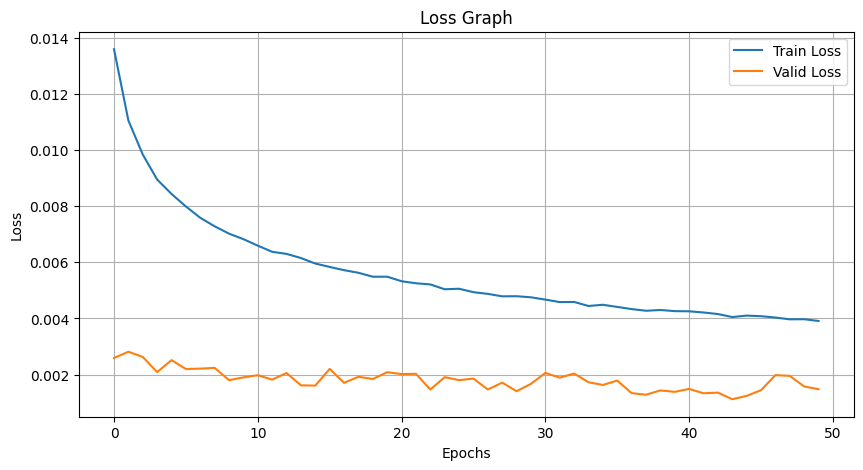

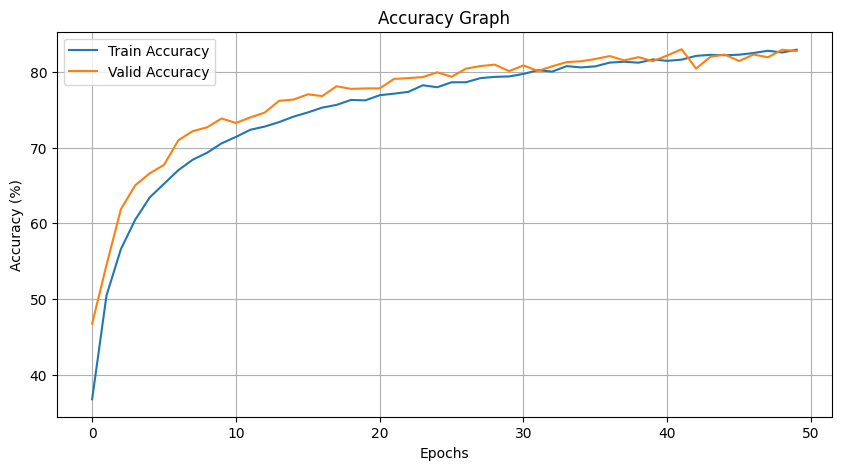

In [215]:
import matplotlib.pyplot as plt

# 텐서를 CPU로 이동하고 넘파이로 변환하는 함수
def tensor_to_numpy(tensor_list):
    return [t.cpu().numpy() if isinstance(t, torch.Tensor) else t for t in tensor_list]

# 손실 그래프 그리기
def plot_loss(train_losses, valid_losses):
    # 텐서를 CPU로 옮기고 넘파이로 변환
    train_losses = tensor_to_numpy(train_losses)
    valid_losses = tensor_to_numpy(valid_losses)
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.title('Loss Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# 정확도 그래프 그리기
def plot_accuracy(train_accs, valid_accs):
    # 텐서를 CPU로 옮기고 넘파이로 변환
    train_accs = tensor_to_numpy(train_accs)
    valid_accs = tensor_to_numpy(valid_accs)

    plt.figure(figsize=(10, 5))
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(valid_accs, label='Valid Accuracy')
    plt.title('Accuracy Graph')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

# 훈련 및 검증 후 손실 및 정확도 그래프 그리기
plot_loss(train_losses, valid_losses)
plot_accuracy(train_accs, valid_accs)

## 모델/하이퍼파라미터/데이터증강에 따른 모델 정확도 비교

<span style="color:orange ; font-weight:bold; font-size:24px;">
    CIFAR10Net + 기본데이터(epochs = 50)
    <br>
    test acc = 83.220
    
</span>

**[test accuracy]**  
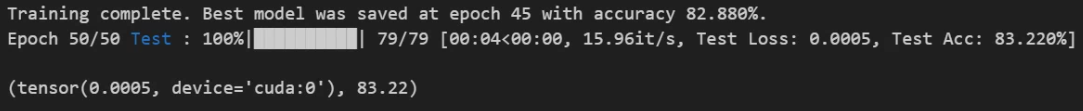

<span style="color:orange ; font-weight:bold; font-size:24px;">
    EfficientNet b0 + 기본데이터(epochs = 50)
    <br>
    test acc = 86.410
</span>

**[valid accuracy]**   
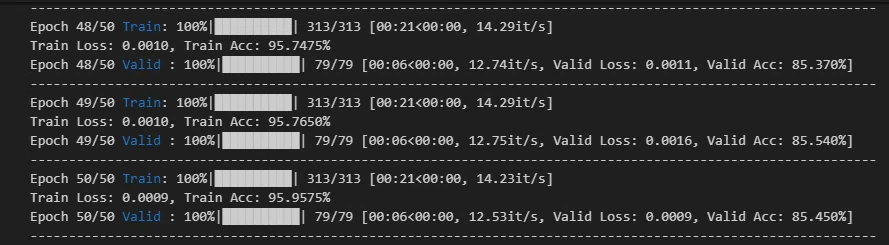   
**[test accuracy]**   
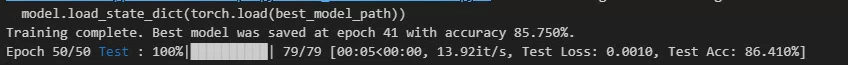

<span style="color:orange ; font-weight:bold; font-size:24px;">
    EfficientNet b0 + 추가증강데이터(epochs = 50)
    <br>
    86.150
</span>

**[valid accuracy]**   
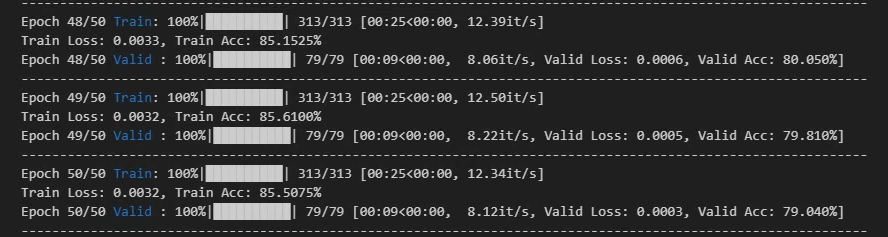   
**[test accuracy]**   
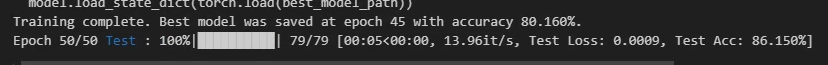


<span style="color:orange ; font-weight:bold; font-size:24px;">
    EfficientNet b1 + 기본데이터(epochs = 50)
    <br>
    test acc = 86.920
</span>

**[valid accuracy]**   
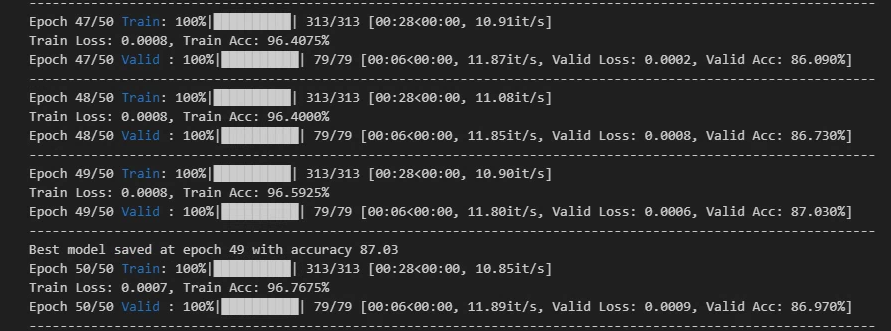   
**[test accuracy]**   
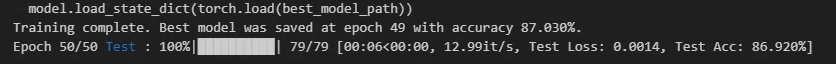


<span style="color:orange ; font-weight:bold; font-size:24px;">
    EfficientNet b1 + 추가증강데이터(epochs = 100)
    <br>
    test acc = 86.740
</span>

cifar10같은 비교적 가벼운 데이터셋에는 무리하게 추가로 데이터를 증강하여 학습시키는 것이 오히려 학습에 방해가 되는 점 확인함   
(에폭수 50일때 정확도가 80에 미치지 못함 - 하지만 테스트 정확도는 다른 케이스들과 비슷했음)   
그래서 혹시 더 학습을 시키면 좋은 결과를 볼 수 있을까 실험해봄 

**[valid accuracy]**   
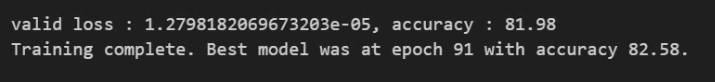   
**[test accuracy]**   
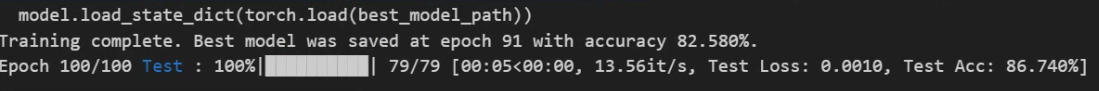   

**[loss graph]**   
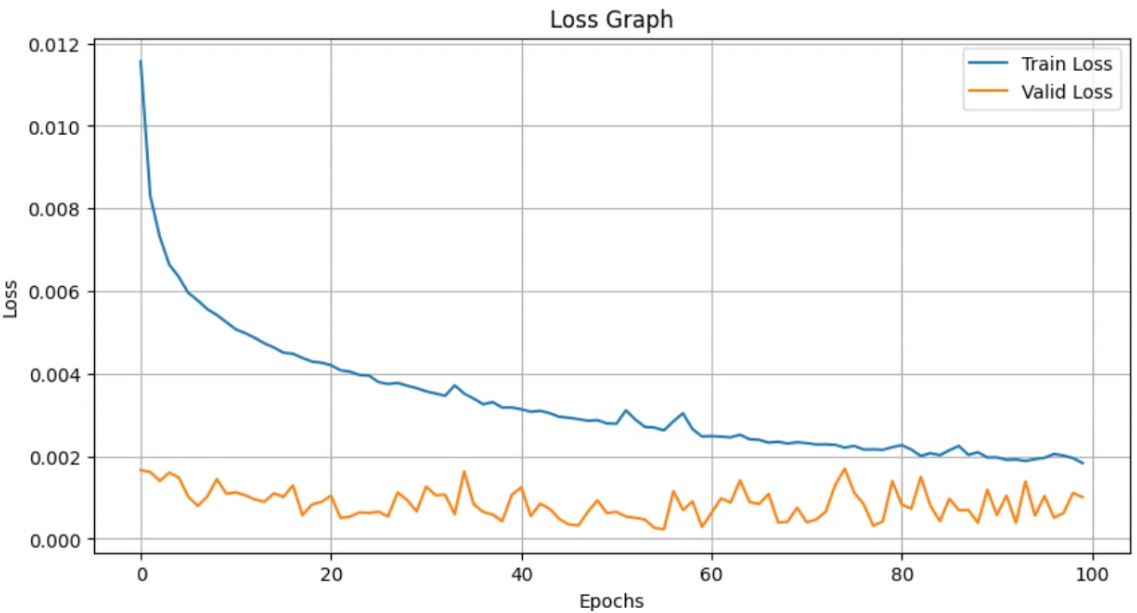   

**[acc graph]**    
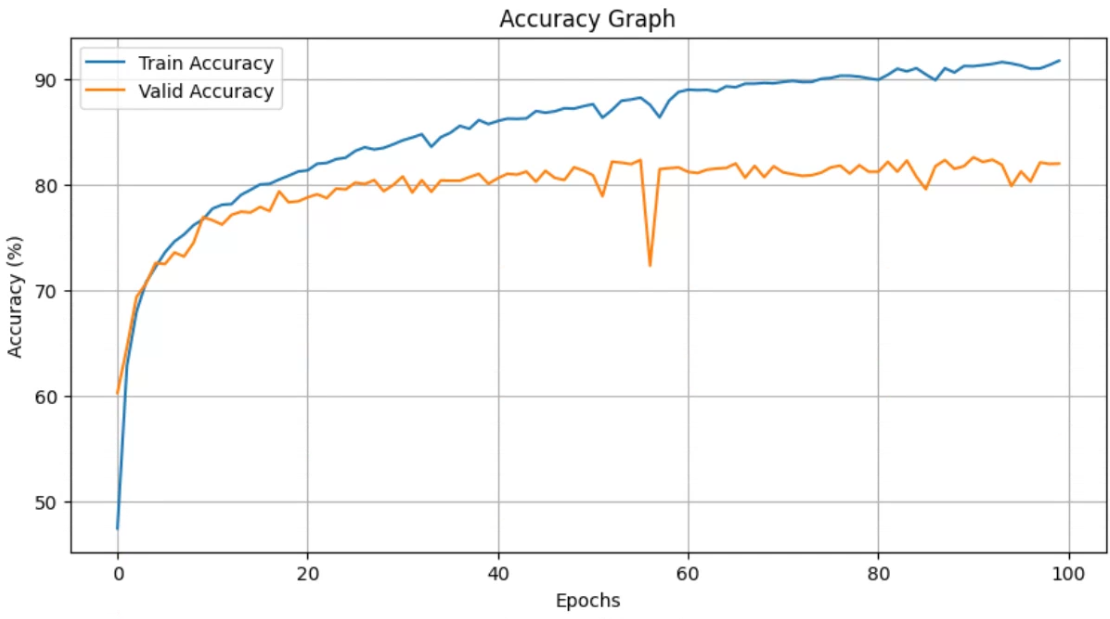   



<span style="color:orange ; font-weight:bold; font-size:24px;">
    EfficientNet b2 + 기본데이터(epochs = 50)
    <br>
    test acc = 86.490
    valid acc = 87.170
</span>

**[valid accuracy]**   
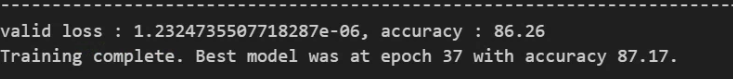     
**[test accuracy]**   
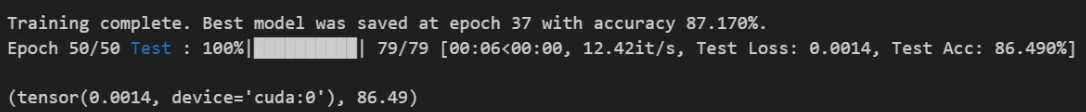   



<span style="color:orange ; font-weight:bold; font-size:24px;">
    LesNet34 + 추가증강데이터(epochs = 50/ optimizer = Adam)
    <br>
    학습시간 = 12분 38초
    <br> 
    test acc = 
</span>

**[valid accuracy]**   
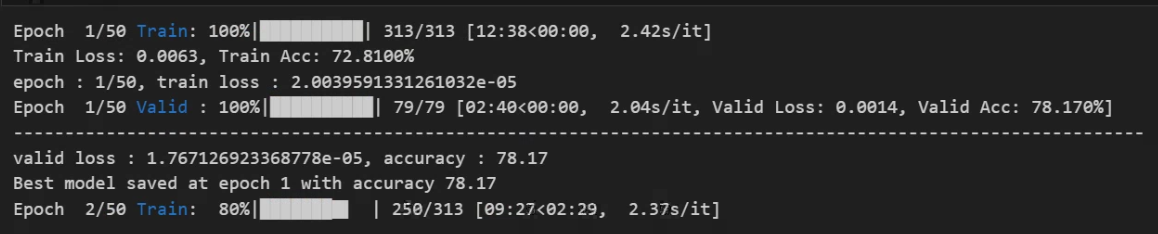
  

<span style="color:orange ; font-weight:bold; font-size:24px;">
    LesNet34 + 추가증강데이터(epochs = 50/ optimizer = SGD)
    <br>
    학습시간 = 10분 58초
    <br> 
    test acc = 
</span>